# Monte Carlo methods


Random number generation (RNG) is an algorithm or a process that generates a sequence of numbers (not just a single number) that cannot be reasonably predicted better than by random chance.

True RNG can rely on physical quantities that are constantly changing in a manner that is practically impossible to model to generate random numbers. However, we do not need truly random numbers, unless the problem we are dealing with is related to security (e.g. encryption keys) or the basis of application is the randomness (e.g. Digital roulette wheels). These are a very specific applications that would require a thorough discussion.

### Psedorandom number generators

In the majority of the cases, absolute randomness is not required; what is important is that the sequence of numbers is *almost* random. **Pseudorandom number generators** (PRNGs) that generate numbers that only look random but are in fact pre-determined, as these generations can be reproduced simply by knowing the initial state (**seed**) of the algorithm.
This feature is important because it allows *reproducibility* of the results, if the same algorithm and seed is used.

While psuedorandom numbers are generated by a deterministic algorithm, we can mostly treat them as if they were true random numbers and we will drop the "pseudo" prefix. Fundamentally, the algorithm generates random integers which are then normalized to give a floating point number from the standard uniform distribution. Random numbers from other distributions are generated using these uniform random distributions.

## The Linear Congruential Generators (LCG) algorithm

[LCG](https://en.wikipedia.org/wiki/Linear_congruential_generator) is among the simplest and most popular pseudo random number generators. It relies on the recursive and fully deterministic relation:

$$
z_{i+1}=(a z_i+c) \mod{m}
$$

where:
   * the **modulus** $m$ is $m>0$
   * the **multiplier** $a$ is $0 < a < m$
   * the **increment** $c$ is $0 \leq c < m$
   * and $z_0$ is the initial value, or **seed**.

The Hull-Dobell theorem states that the LCG algorithm will have a period $m$ for all seeds only if:

* $c$ and $m$ are relatively prime,
* $a−1$ is divisible by all prime factors of $m$
* $a−1$ is a multiple of 4 if $m$ is a multiple of $4$.

The **seed** $z_0$ allows to have a reproducible sequence of (pseudo) random numbers.

The LCG is typically coded to return $z/m$, a floating point number in the $[0, 1]$ range. 
From the modulus definition, $z \le m-1$ always holds, and therefore the yielded $z/m$ result is thus strictly smaller than 1. Obviously, the output can be easily scaled to any range $[a, b]$.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
#%precision 4

#Usually m is a big number
def lcg(m=2**32, a=1103515245, c=12345):
    # get seed
    global x
    x = (a*x + c) % m
    return x/m

# setting the seed
x = 12345678

# generate a set of 10 random numbers by calling lgc() 10 times
print([lcg() for i in range(10)])

[0.7741605301853269, 0.13679382111877203, 0.02637076494283974, 0.13673808285966516, 0.007716568885371089, 0.4041025284677744, 0.7072384061757475, 0.06444240501150489, 0.354662919184193, 0.15596282947808504]


Mean: 0.5040368471393362
Std: 0.28904666474556634 , expectation from flat pdf: 0.2886751345948129


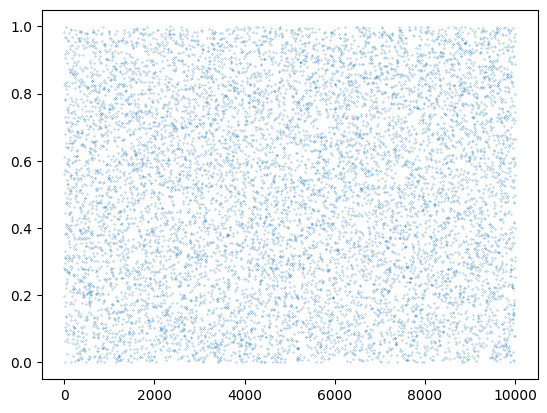

In [2]:
rn = [lcg() for i in range(10000)]
print("Mean:", np.mean(rn))
print("Std:", np.std(rn), ", expectation from flat pdf:", 1./np.sqrt(12))
plt.plot(rn, 'o', markersize=0.2)

Even though it's difficult to spot tiny correlations by eye, LCG is not sufficiently "random" for several complex modern applications. There are nowadays better performing algorithms, like the [Mersenne twister](https://en.wikipedia.org/wiki/Mersenne_Twister), a generalized feedback shift-register generator, which is used in particular by Microsoft Excel.

Numpy uses as default [PCG-64](https://numpy.org/doc/stable/reference/random/bit_generators/index.html) of the [PCG family](https://www.pcg-random.org/), which are considered the ultimate random number generators.

## Non-uniform random numbers

In several cases, the user is interested in random number generation with non-uniform probability, i.e. with a given probability density function (pdf) different from the uniform (flat) distribution.

There are several methods available; we will explore few of them.

### Inverse Transform method

The Inverse Transform method is the most elegant solution, however its applicability is restricted to only few cases.

Consider $X$ a continuous random sample with pdf $f(X)$ and cumulative distribution function (CDF) $F(X)$. The [probability integral transform](https://en.wikipedia.org/wiki/Probability_integral_transform) states that the random sample $Y=F_{X}(X)$ has a uniform distribution in the $[0, 1]$ range.

By inverting the theorem, if $Y$ has a uniform distribution on $[0, 1]$, then the random variable $F^{−1}_{X}(Y)$ has the same distribution as $X$.

Of course, in order to be able to apply this method, the *analytic form of the CDF* has to be known, and *it can be inverted*.

In other words, we can map the uniform random distribution to a generic distribution $X$ if we know the inverse function of the cumulative distribution of $f$.

A visual example can be found [here](https://en.wikipedia.org/wiki/Inverse_transform_sampling).


#### Example: the inverse transform method from the exponential distribution

in case of an exponential distribution, ($f(x) = \lambda e^{-\lambda x}$), the CDF is:

$$
F_X(x) = \int_0^x f(x') dx' = \int_0^x \lambda e^{-\lambda x'} dx' = 1 - e^{-\lambda x} = y
$$

inverting and solving for $x$:

$$x = F^{-1}(y) = -\frac{1}{\lambda} \log(1-y)$$

Text(0.5, 1.0, 'Histogram of exponential random number distribution')

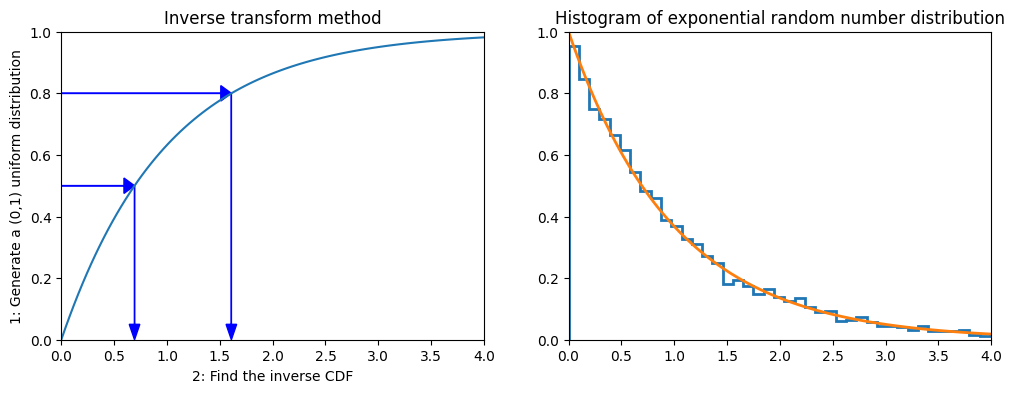

In [4]:
def expon_pdf(x, mu=1):
    """PDF of exponential distribution."""
    return mu * np.exp(-mu*x)

def expon_cdf(x, mu=1):
    """CDF of exponetial distribution."""
    return 1 - np.exp(-mu*x)

def expon_icdf(p, mu=1):
    """Inverse CDF of exponential distribution - i.e. quantile function."""
    return -np.log(1 - p)/mu



plt.figure(figsize=(12, 4))
plt.subplot(121)
x = np.linspace(0, 4, 100)
plt.plot(x, expon_cdf(x)) # plot exponential CDF
# plot the arrows
plt.axis([0, 4, 0, 1])
for q in [0.5, 0.8]:
    plt.arrow(0, q, expon_icdf(q)-0.1, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
    plt.arrow(expon_icdf(q), q, 0, -q + 0.05, head_width=0.1, head_length=0.05, fc='b', ec='b')
plt.ylabel("1: Generate a (0,1) uniform distribution")
plt.xlabel("2: Find the inverse CDF")
plt.title("Inverse transform method")

plt.subplot(122)

#Create random numbers
u = np.random.random(10000)
v = expon_icdf(u) # apply the inverse of the CDF

plt.hist(v, histtype='step', bins=100, density=True, linewidth=2)  # plot histogram of the sample v
plt.plot(x, expon_pdf(x), linewidth=2)  # plot exponential PDF
plt.axis([0, 4, 0, 1])
plt.title("Histogram of exponential random number distribution")

### The Box-Muller transform for generating normally distributed random numbers

The inverse method is not applicable for more complex functions, for instance it does not work even for the gaussian distribution, because:

$$
\frac{1}{\sqrt{2\pi\sigma^2}}\int_{-\infty}^{x} e^{-\frac{x'^2}{2\sigma^2}} dx' = y
$$

is not solvable.

The (mathematical) trick is to consider a two dimensional gaussian function with the same $\sigma$ on both coordinates:

$$
f(x)dx \cdot f(y)dy = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{x^2}{2\sigma^2}} \cdot \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{y^2}{2\sigma^2}} = \frac{1}{2\pi\sigma^2} e^{-\frac{(x^2+y^2)}{2\sigma^2}}dxdy
$$

which written in radial coordinates:

$$
x=r\cos{\theta};\,\,\,
y=r\sin{\theta};\,\,\,
dxdy = r dr d\theta
$$

$$
f(r,\theta)dr d\theta = \frac{r}{\sigma^2} e^{-\frac{r^2}{2\sigma^2}} dr \cdot \frac{d\theta}{2\pi} = f(r)dr \cdot f(\theta)d\theta
$$

with both $f(r)$ and $f(\theta)$ are normalized to 1. We have now factorized the part that depends on $r$ and the one that depends only on $\theta$. Now, the latter is a simple uniform distribution, whereas the former is solvable:

$$
\frac{1}{\sigma^2} \int_{0}^{r} e^{-\frac{{r'}^{2}}{2\sigma^2}} {r'} d{r'} = - e^{-\frac{{r}^{2}}{2\sigma^2}} + 1 = y
$$

which gives:

$$
r=\sqrt{-2\sigma^2\log{(1-y)}}
$$


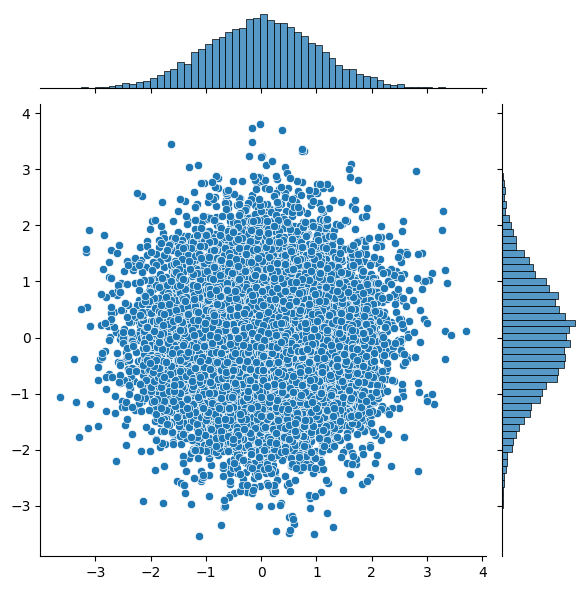

In [5]:
n = 10000
# here we assume sigma = 1
theta = 2 * np.pi * np.random.random(n) # generate uniform distribution in theta [0, 2pi]
Y = np.random.random(n) # generate uniform distribution
r = np.sqrt(-2 * np.log(Y)) # pass Y to the Box-Muller transform formula
x = r * np.cos(theta)
y = r * np.sin(theta)

# scatter plot with projections
sns.jointplot(x=x, y=y, kind='scatter')

### Functions whose analytic pdfs are known (and implemented in SciPy)

If you are lucky enough, the distribution you want to generate is included in the list of functions of the `scipy.stats` module. This is a link to the list of the [implemented functions](https://docs.scipy.org/doc/scipy/reference/stats.html).

Each function has these convenient methods:

   - `ppf()`, that returns the inverse of cdf (here called Percent Point Function)
   - `rvs()`, which creates a random sample of given size

You can draw random data from each of these functions, in this example the Gamma function:

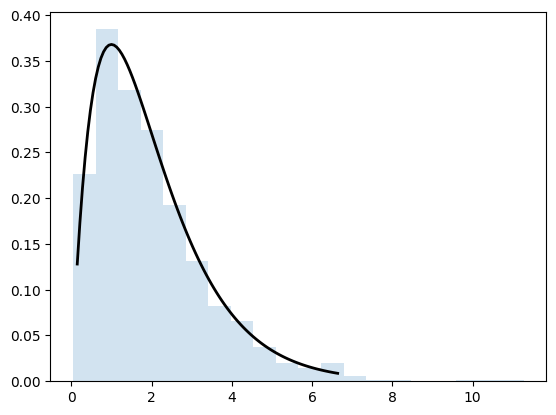

In [6]:
from scipy.stats import gamma
a = 2. # set function parameters

x = np.linspace(gamma.ppf(0.01, a), gamma.ppf(0.99, a), 100)
fig, ax = plt.subplots(1, 1)

# plot the function
_ = ax.plot(x, gamma(a).pdf(x), 'k-', lw=2)

# generate a sample r according to the gamma function
#size => size of the sample we want to generate
r = gamma.rvs(a, size=1000)
_ = ax.hist(r, 20, density=True, histtype='stepfilled', alpha=0.2)

### Creating a random number generator for arbitrary distributions via interpolation

Suppose we have some random samples with an unknown distribution. We can still use the inverse transform method to create a random number generator from a random sample, by estimating the inverse CDF function using interpolation.

Text(0.5, 1.0, 'Interpolated CDF')

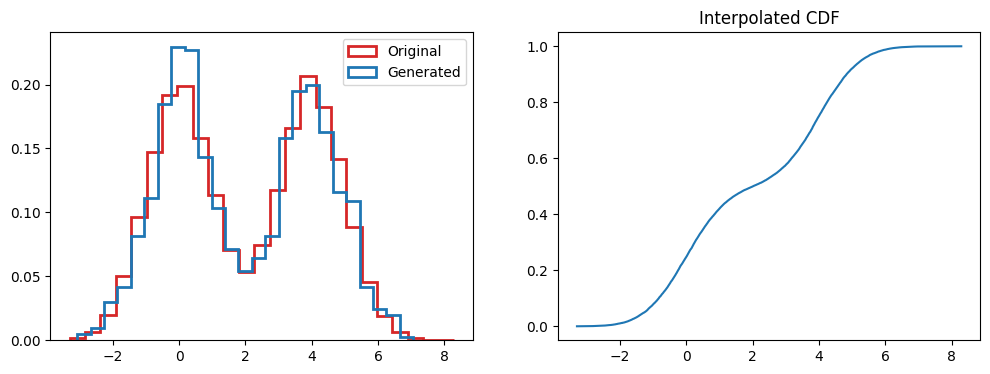

In [8]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d

def extrap1d(interpolator):
    """From StackOverflow http://bit.ly/1BjyRfk"""
    xs = interpolator.x
    ys = interpolator.y

    def pointwise(x):
        # extrapolation below min
        if x < xs[0]:
            return ys[0]+(x-xs[0])*(ys[1]-ys[0])/(xs[1]-xs[0])
        # extrapolation above max
        elif x > xs[-1]:
            return ys[-1]+(x-xs[-1])*(ys[-1]-ys[-2])/(xs[-1]-xs[-2])
        # interpolation if in range
        else:
            return interpolator(x)

    def ufunclike(xs):
        return np.array(list(map(pointwise, np.array(xs))))

    return ufunclike



# Create a dataset composed by two gaussians with width = 1 but different mean
x = np.concatenate([np.random.normal(0, 1, 10000), np.random.normal(4, 1, 10000)])

ecdf = ECDF(x) # returns the Empirical CDF of an array as a step function
inv_cdf = extrap1d(interp1d(ecdf.y, ecdf.x, bounds_error=False, assume_sorted=True)) # estimate the inverse of the CDF
r = np.random.uniform(0, 1, 1000)
ys = inv_cdf(r)


plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(x, 25, histtype='step', color='tab:red', density=True, linewidth=2, label="Original")
plt.hist(ys, 25, histtype='step', color='tab:blue', density=True, linewidth=2, label="Generated")
plt.legend()

plt.subplot(122)
plt.plot(ecdf.x, ecdf.y)
plt.title("Interpolated CDF")

### Rejection sampling (Accept-reject method)

Even if it's not always possible to have an analytical solution to some problems, there are numerical or approximated methods that may come to help.

The *Rejection Sampling method* is based on the observation that a random variable in one dimension can be sampled by performing an uniform random sampling of the two-dimensional Cartesian graph, and retain the samples in the region under the graph.

This property can be extended to N-dimension functions, however it is not ideal in higher dimensions (because of the numer of points that have to be generated to to sample the N-dimensional space).

#### Example: sampling the (truncated) Cauchy distribution

Text(0.5, 1.0, 'Histogram of accepted samples')

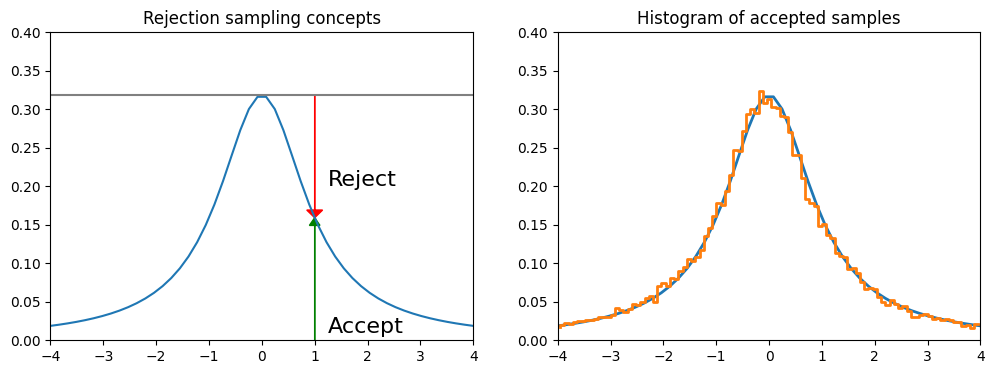

In [9]:
x = np.linspace(-4, 4)

dist = stats.cauchy()
upper = dist.pdf(0) # max of the function

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(x, dist.pdf(x))
plt.axhline(upper, color='grey')
px = 1.0
plt.arrow(px, 0, 0, dist.pdf(1.0)-0.01, linewidth=1, head_width=0.2, head_length=0.01, fc='g', ec='g')
plt.arrow(px, upper, 0, -(upper-dist.pdf(px)-0.01), linewidth=1, head_width=0.3, head_length=0.01, fc='r', ec='r')
plt.text(px + 0.25, 0.2, 'Reject', fontsize=16)
plt.text(px + 0.25, 0.01, 'Accept', fontsize=16)
plt.axis([-4, 4, 0, 0.4])
plt.title("Rejection sampling concepts")

# Accept-reject method
n = 100000
# generate from sampling distribution
#numpy arrays along x
u = np.random.uniform(-4, 4, n)
# accept-reject criterion for each point in sampling distribution
#numpy arrays along y (upper = maximum value of the function)
r = np.random.uniform(0, upper, n)
# accepted points will come from target (Cauchy) distribution
#wich element fall bellow 
v = u[r < dist.pdf(u)]

plt.subplot(122)
plt.plot(x, dist.pdf(x), linewidth=2)

# Plot scaled histogram
factor = dist.cdf(4) - dist.cdf(-4)
hist, bin_edges = np.histogram(v, bins=100, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
plt.step(bin_centers, factor*hist, linewidth=2)

plt.axis([-4, 4, 0, 0.4])
plt.title("Histogram of accepted samples")

#Major drawback of this method : 
#the function needs to take the major part of the "box"
#si la fonction prends pas bcp de places, enormement de point vont être reject...
#need to draw a lot of points in order to have a reasonnable point bellow the function

## Monte Carlo integration

Monte Carlo integration is typically less accurate than other integration methods, but very often is the only available tool, e.g. when the integrand has very rapid variations or singular points, or, most importantly, when dealing with high dimensional integrals.

The idea is simple: the area under the function is the integral $I$ whereas the all possible outcomes lay in a box of area $A$. The probability for a point to fall under the function is $p=I/A$. If we generate $N$ random points, the fraction $k$ which fall under the curve is $k/N$ and approximate $I/A$, thus:

$$
I\simeq\frac{k A}{N}
$$


#### Example: the integral of the function $f(x) =\sin^2{\left( \frac{1}{x(2-x)} \right)}$

With an integration domain $x \in [0, 2]$ and $y \in [0, 1]$.

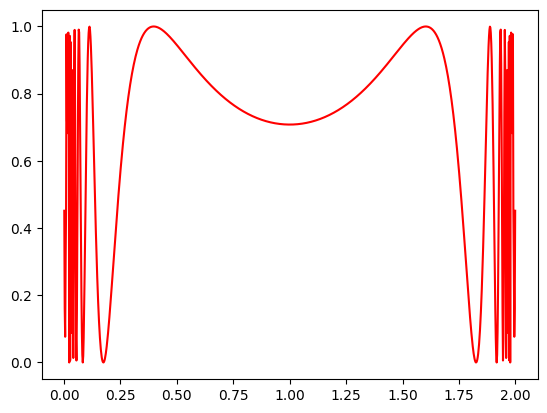

In [10]:
def f(x):
    return (np.sin(1. / (x * (2 - x))))**2

x=np.linspace(0.001, 1.999, 1000)
plt.plot(x, f(x), 'r-')
#we can see that it is hard to integrate => we need to use Monte Carlo

In [12]:
# Monte Carlo integration
N = 100000
count = 0
for i in range(N):
    x = 2 * np.random.random() # x is random uniform between 0 and 2
    y = np.random.random()     # y is random uniform between 0 and 1
    if y < f(x): count += 1
I = 2 * count / N
print("Integral:", I)

Integral: 1.45074


### The mean value method

Let's take the integral:

$$
I=\int_a^b f(x) dx
$$

and the definition of $\langle f \rangle$ as the mean of $f$:

$$
\langle f \rangle = \frac{1}{b-a}\int_a^b f(x) dx
$$

and estimating $\langle f \rangle$ by uniformely probing at random the function domain, such as

$$
\langle f \rangle = \frac{1}{N} \sum_{i=1}^{N} f(x_i)
$$

By combining the previous definitions, we get:

$$
I=\frac{b-a}{N} \sum_{i=1}^{N} f(x_i)
$$

this easily generalize to higher dimensions:

$$
I=\frac{V}{N} \sum_{i=1}^{N} f(\vec{r}_i)
$$

where the sampling points $\vec{r}_i$ are drawn uniformly at random inside the integration space of volume $V$.

It can be proven that the standard deviation of the method scales as $1/\sqrt{N}$:

$$
\sigma = V\frac{\sqrt{{\rm var}\, f}}{\sqrt{N}}
$$

### Importance sampling

There are several general techniques for variance reduction, sometimes known as Monte Carlo swindles since these methods improve the accuracy and convergence rate of Monte Carlo integration without increasing the size of the Monte Carlo sample. *Importance sampling* is among the most commonly used.

We can define a weighted average of a function $g(x)$:

$$
\langle g_w \rangle = \frac{\int_a^b w(x) g(x)dx}{\int_a^b w(x)dx}
$$

Consider again the integral of $f(x)$:

$$
I=\int_a^b f(x)dx
$$

Setting $g(x)=f(x)/w(x)$ we have:

$$
\left\langle \frac{f(x)}{w(x)}\right\rangle = \frac{\int_a^b w(x)\frac{f(x)}{w(x)} dx}{\int_a^b w(x)dx} = \frac{I}{\int_a^b w(x)dx}
$$

and since $\left\langle \frac{f(x)}{w(x)}\right\rangle \approx \frac{1}{N}\sum_{i=1}^N \frac{f(x_i)}{w(x_i)}$, we obtain thus:

$$
I = \left\langle \frac{f(x)}{w(x)}\right\rangle \int_a^b w(x)dx \simeq \frac{1}{N}\sum_{i=1}^N \frac{f(x_i)}{w(x_i)}\int_a^b w(x)dx
$$

which is a generalization of the mean value method. If $w(x)$ is the uniform distribution between $a$ and $b$, then the result coincides with the mean value method.

#### Example: the tail of a normal distribution

Suppose we want to estimate the tail probability of ${\cal N}(0,1)$ for $P(x>5)$. Regular MC integration using samples from ${\cal N}(0,1)$ is hopeless since nearly all samples will be rejected.

However, we can use the importance sampling method and the exponential density truncated at 5 as the weight function.

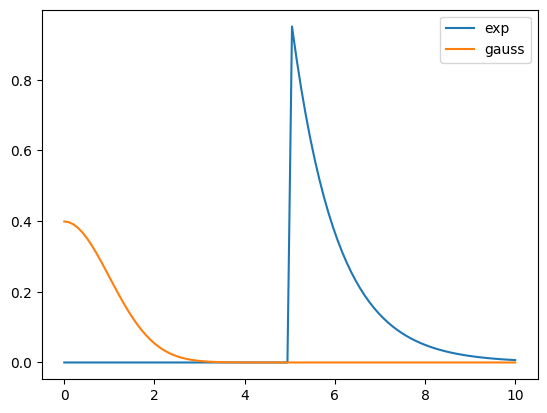

In [18]:
x = np.linspace(0, 10, 100)
plt.plot(x, stats.expon(5).pdf(x), label='exp')
plt.plot(x, stats.norm().pdf(x), label='gauss')
plt.legend()

First, let's find the true value of the integral for future comparisons:

In [19]:
%precision 10
h_true = 1 - stats.norm().cdf(5)
print("True integral:", h_true)

True integral: 2.866515719235352e-07


To begin with, let's see what happens when using the non-weighted integration:

In [20]:
n = 1000000

# generate a distribution of random points
y = stats.norm().rvs(n)

# sum only those that are below the graph
h_mc = 1.0 / n * np.sum(y > 5)

# estimate and relative error
print("MC integral:", h_mc, ", rel. err:", np.abs(h_mc - h_true)/h_true)

MC integral: 1e-06 , rel. err: 2.4885557866982557


Finally, let's use the importance sampling method with the exponential function as weight:

In [21]:
# note that we are generating 10k random numbers instead of 1M
n = 10000

# generate a distribution of random points according to the weight function
y = stats.expon(loc=5).rvs(n)

# calculate the normalization factor given by the integral of the weight function over the integration domain (in this case, it's 1)
w_int = stats.expon(loc=5).cdf(y.max())

# compute the integral with the importance sampling method
h_is = 1.0 / n * np.sum(stats.norm().pdf(y) / stats.expon(loc=5).pdf(y)) * w_int

# estimate and relative error
print("IS integral:", h_is, ", rel. err:", np.abs(h_is - h_true)/h_true)

IS integral: 2.865404595508318e-07 , rel. err: 0.000387621710768104
